PRE-INSTALLATION OF ALL THE USED PACKAGES AND LIBRARIES

In [1]:
%pip install --upgrade pip
%pip install SPARQLWrapper pandas matplotlib numpy Pillow requests scikit-learn ipywidgets


Defaulting to user installation because normal site-packages is not writeable
Note: you may need to restart the kernel to use updated packages.
Defaulting to user installation because normal site-packages is not writeable
Note: you may need to restart the kernel to use updated packages.


The following Python script queries Wikidata for information about cars, downloads their images, and extracts metadata, including image size, format, orientation, creation date, and EXIF data. The script handles potential errors during image processing and saves the metadata for the downloaded images in a JSON file. The goal is to create a comprehensive dataset of car images with associated metadata for further analysis or use.

In [2]:

import os
from SPARQLWrapper import SPARQLWrapper, JSON
from PIL import Image
import json
import urllib
import time
import re
from PIL.ExifTags import TAGS

endpoint_url = "https://query.wikidata.org/sparql"

query = """SELECT DISTINCT ?car ?carLabel ?image {
  ?car wdt:P31 wd:Q1420;
       wdt:P18 ?image.
 SERVICE wikibase:label { bd:serviceParam wikibase:language "en". }
}
LIMIT 10"""

def get_results(endpoint_url, query):
    user_agent = "me/1.0 (me@email.com)"
    sparql = SPARQLWrapper(endpoint_url, agent=user_agent)
    sparql.setQuery(query)
    sparql.setReturnFormat(JSON)
    return sparql.query().convert()

def download_image_metadata(images_folder, data, limit=10):
    # Ensure the images folder exists
    if not os.path.exists(images_folder):
        os.makedirs(images_folder)

    # List to accumulate metadata for all images
    all_metadata = []

    for i, result in enumerate(data["results"]["bindings"]):
        if i >= limit:
            break

        car_label = result.get("carLabel", {}).get("value", f"UnknownCar_{i + 1}")
        # Remove special characters from the car label for file path
        car_label_cleaned = re.sub(r'\W+', '', car_label)
        image_url = result.get("image", {}).get("value", "")

        image_name = f"{car_label_cleaned}_image_{i + 1}.jpg"
        image_path = os.path.join(images_folder, image_name)

        try:
            # Download the image from Wikidata
            urllib.request.urlretrieve(image_url, image_path)

            print(f"Downloaded: {image_name}")

            # Get metadata and accumulate in the list
            metadata = get_metadata(image_path)
            all_metadata.append(metadata)

            # Introduce a delay between requests to comply with rate limits
            time.sleep(1)

        except Exception as e:
            print(f"Error processing image {image_name}: {e}")

    # Ensure the json folder exists
    if not os.path.exists(json_folder):
        os.makedirs(json_folder)
        
    # Save all metadata to a single JSON file
    json_file_path = os.path.join(json_folder,"metadata.json")
    with open(json_file_path, "w") as json_file:
        json.dump(all_metadata, json_file, indent=4)

    print(f"All metadata saved to: {json_file_path}")


def get_exif_metadata(exif_data):
    if exif_data:
        exif_metadata = {}
        for tag, value in exif_data.items():
            tag_name = TAGS.get(tag, tag)
            # Exclude problematic values
            if isinstance(value, bytes):
                continue
            # Convert non-serializable types to string
            if isinstance(value, (str, int, float)):
                exif_metadata[tag_name] = value
            else:
                exif_metadata[tag_name] = str(value)
        return exif_metadata
    return {}

def get_metadata(image_path):
    with Image.open(image_path) as img:
        exif_data = img._getexif()  # Get EXIF data
        metadata = {
            "image_name": os.path.basename(image_path),
            "image_size": img.size,
            "image_format": img.format,
            "image_orientation": get_image_orientation(exif_data),
            "creation_date": get_creation_date(exif_data),
            "exif_metadata": get_exif_metadata(exif_data),
        }
        return metadata

def get_image_orientation(exif_data):
    if exif_data:
        orientation = exif_data.get(274)  # 274 corresponds to the 'Orientation' tag
        if orientation is not None:
            return orientation
    return "Unknown"

def get_creation_date(exif_data):
    if exif_data:
        date_time_original = exif_data.get(36867)  # 36867 corresponds to 'DateTimeOriginal' tag
        if date_time_original is not None:
            return date_time_original
    return "Unknown"

if __name__ == "__main__":
    # Specify the folder paths
    images_folder = "*images*"
    json_folder = "*json*"

    # Get results from Wikidata
    results = get_results(endpoint_url, query)

    # Download images and save metadata
    download_image_metadata(images_folder, results, limit=10)



Downloaded: Kharkovchanka_image_1.jpg
Downloaded: Ferrari250GTBoanoEllenacar_image_2.jpg
Downloaded: Fiat770_image_3.jpg
Downloaded: CampagnaTRex_image_4.jpg
Downloaded: CG1200S_image_5.jpg
Downloaded: VAZ2104_image_6.jpg
Downloaded: Fiat1500Lcar_image_7.jpg
Downloaded: Fiat500Giardiniera_image_8.jpg
Downloaded: Ferrari250P_image_9.jpg
Downloaded: GeelyKingKong_image_10.jpg
All metadata saved to: *json*/metadata.json


Now, we are going to use the following script to determine the 3 predominant colors in each image by using Random Forest Classifier. The script will also create a new dataset with the image metadata and the 3 predominant colors for each image.


In [3]:
import os
import json
from PIL import Image
import pandas as pd
from sklearn.cluster import KMeans

def extract_colors(image_path, num_colors=3):
    image = Image.open(image_path)
    # Resize the image to a small size for faster processing
    resized_image = image.resize((50, 50))
    pixels = list(resized_image.getdata())

    # Use K-Means clustering to find the predominant colors
    kmeans = KMeans(n_clusters=num_colors)
    kmeans.fit(pixels)
    predominant_colors = kmeans.cluster_centers_.astype(int)

    return predominant_colors.tolist()

def process_images(folder_path, num_colors=3):
    data = []

    for filename in os.listdir(folder_path):
        if filename.endswith(('.jpg', '.jpeg', '.png')):
            image_path = os.path.join(folder_path, filename)
            colors = extract_colors(image_path, num_colors)
            data.append({'Image': filename, 'Predominant Colors': colors})

    return pd.DataFrame(data)


if __name__ == "__main__":
    folder_path = "*images*"  # Replace with the actual path to your image folder
    output_json_path = "*json*/predominant_colors.json"  # Replace with the actual path for the output JSON file

    # Process images and create DataFrame
    df = process_images(folder_path)

    # Save the DataFrame to a JSON file
    df.to_json(output_json_path, orient='records')
    
    data = json.load(open(output_json_path))
    dataframe = pd.json_normalize(data)
   
    print(dataframe)
    
    
    


                                    Image  \
0               Kharkovchanka_image_1.jpg   
1              GeelyKingKong_image_10.jpg   
2                     CG1200S_image_5.jpg   
3                     Fiat770_image_3.jpg   
4          Fiat500Giardiniera_image_8.jpg   
5                     VAZ2104_image_6.jpg   
6                Fiat1500Lcar_image_7.jpg   
7                CampagnaTRex_image_4.jpg   
8  Ferrari250GTBoanoEllenacar_image_2.jpg   
9                 Ferrari250P_image_9.jpg   

                                 Predominant Colors  
0  [[64, 52, 42], [186, 187, 190], [102, 107, 125]]  
1  [[57, 58, 47], [199, 199, 200], [138, 134, 122]]  
2   [[131, 118, 97], [52, 48, 33], [137, 210, 229]]  
3  [[161, 159, 154], [97, 82, 65], [226, 220, 215]]  
4  [[26, 47, 45], [198, 219, 237], [115, 138, 115]]  
5   [[96, 106, 112], [146, 141, 145], [56, 56, 57]]  
6    [[150, 171, 201], [30, 44, 31], [80, 104, 76]]  
7   [[63, 64, 43], [202, 234, 73], [162, 163, 157]]  
8   [[62, 38, 37],

After that, we will ask the user to select some images and add tags. For every user, we are now ready to build a user-preference profile, based on this selection. We may collect the following information manually, but the objective of this task is to obtain them using the selected images in an automated manner.
The following information will be collected:
    - Favorite colors
    - Favorite image orientation
    - Favorite image sizes (thumbnail images, large images, medium-size images, etc.)
    - Favorite tags



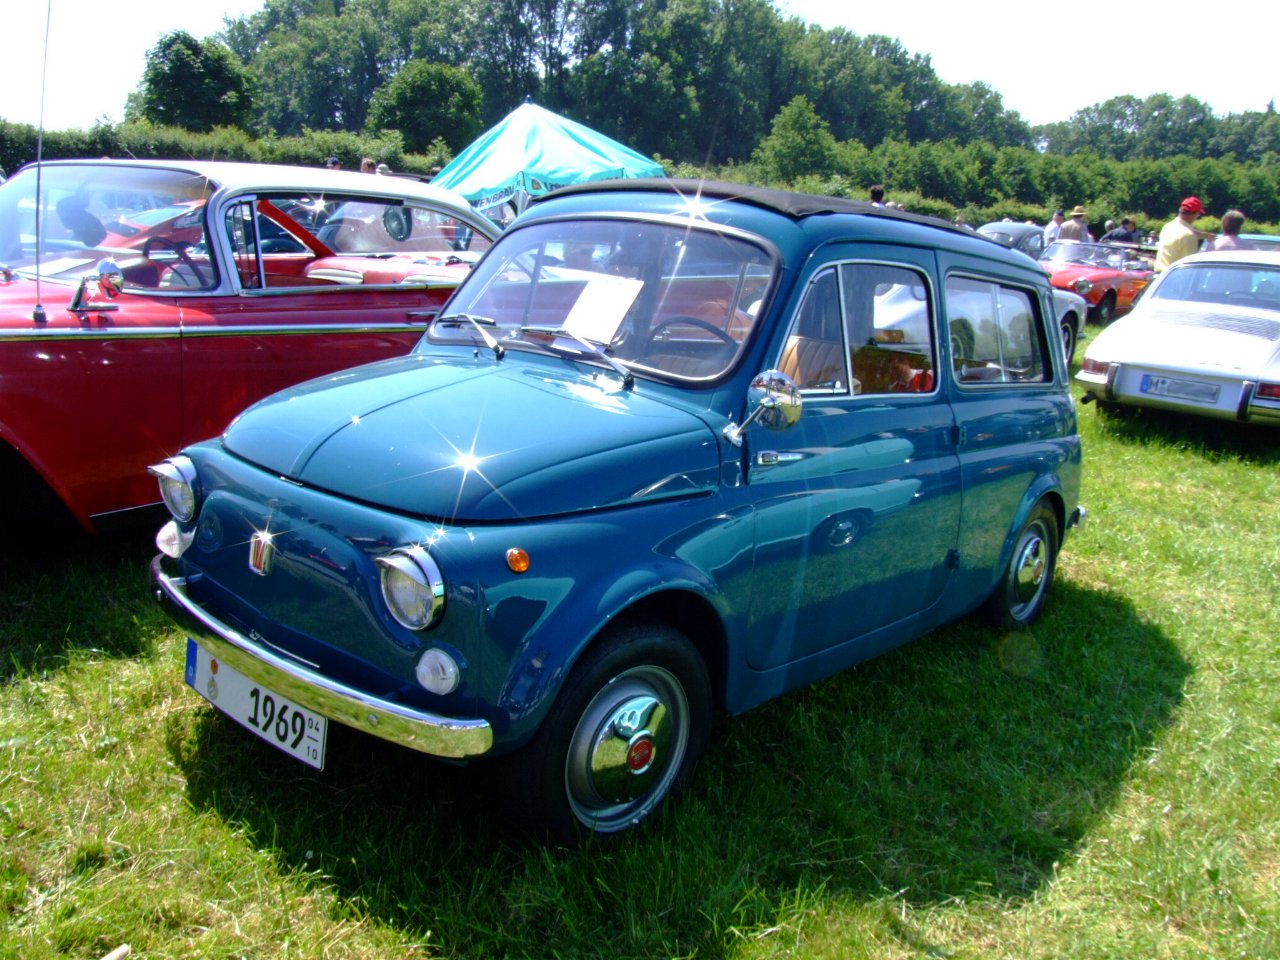

In [5]:
import os
import json
from IPython.display import display, Image, clear_output
import ipywidgets as widgets
import random

# Specify the folder path containing the images
folder_path = "*images*"

# Specify the output JSON file path
output_json_path = "*json*/image_ratings.json"  # Replace with the actual path for the output JSON file

# Create an empty list to store the image ratings
image_ratings = []

# Get the list of image file names in the folder
image_files = [filename for filename in os.listdir(folder_path) if filename.endswith(('.jpg', '.jpeg', '.png'))]

# Shuffle the list of image files
random.shuffle(image_files)

def create_event_handlers(image_file):
    def like_button_clicked(b):
        image_ratings.append({'Image': image_file, 'Preference': 'like'})
        display_next_image()

    def dislike_button_clicked(b):
        image_ratings.append({'Image': image_file, 'Preference': 'dislike'})
        display_next_image()

    return like_button_clicked, dislike_button_clicked

def display_next_image():
    global image_index
    if image_index < len(image_files):
        image_file = image_files[image_index]
        image_widget = Image(filename=os.path.join(folder_path, image_file))
        like_button, dislike_button = create_event_handlers(image_file)
        like_button_widget = widgets.Button(description='Like')
        dislike_button_widget = widgets.Button(description='Dislike')
        like_button_widget.on_click(like_button)
        dislike_button_widget.on_click(dislike_button)
        buttons_box = widgets.HBox([like_button_widget, dislike_button_widget])
        image_widget.height = 300
        image_widget.width = 300
        clear_output(wait=True)
        display(image_widget, buttons_box)
        image_index += 1
    else:
        # All images have been displayed
        clear_output(wait=True)
        print("All images have been rated.")
        # Save the image ratings to the output JSON file
        with open(output_json_path, 'w') as json_file:
            json.dump(image_ratings, json_file, indent=4)
        print("Image ratings saved to:", output_json_path)

# Display the first image
image_index = 0
display_next_image()
